## Imports

In [86]:
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error

## Load the data

In [87]:
tf.keras.utils.get_file(
"bike_sharing_dataset.zip",
"https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip",
cache_dir=".",
extract=True
)

df = pd.read_csv('datasets/hour.csv',
parse_dates={'datetime': ['dteday', 'hr']},
date_format='%Y-%m-%d %H',
index_col='datetime'
)
print((df.index.min(), df.index.max()))
print((365 + 366) * 24 - len(df))
df

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))
165


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01 01:00:00,2,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01 02:00:00,3,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01 03:00:00,4,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01 04:00:00,5,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,17375,1,1,12,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31 20:00:00,17376,1,1,12,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31 21:00:00,17377,1,1,12,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


## 2.2 Format the data

In [88]:
# Filling missing values with 0
df = df.asfreq('H')
df[['casual', 'registered', 'cnt']] = df[['casual', 'registered', 'cnt']].fillna(0)

#Interpolate
df['temp'] = df['temp'].interpolate()
df['atemp'] = df['atemp'].interpolate()
df['hum'] = df['hum'].interpolate()
df['windspeed'] = df['windspeed'].interpolate()

# Fill missing values with previous values (forward-fill), (holiday, weekday, workingday, weathersit)
df = df.fillna(method='ffill')

# Scale the data
df.casual /= 1e3
df.registered /= 1e3
df.cnt /= 1e3
df.weathersit /= 4

df


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1.0,1.0,0.0,1.0,0.0,6.0,0.0,0.25,0.24,0.2879,0.81,0.0000,0.003,0.013,0.016
2011-01-01 01:00:00,2.0,1.0,0.0,1.0,0.0,6.0,0.0,0.25,0.22,0.2727,0.80,0.0000,0.008,0.032,0.040
2011-01-01 02:00:00,3.0,1.0,0.0,1.0,0.0,6.0,0.0,0.25,0.22,0.2727,0.80,0.0000,0.005,0.027,0.032
2011-01-01 03:00:00,4.0,1.0,0.0,1.0,0.0,6.0,0.0,0.25,0.24,0.2879,0.75,0.0000,0.003,0.010,0.013
2011-01-01 04:00:00,5.0,1.0,0.0,1.0,0.0,6.0,0.0,0.25,0.24,0.2879,0.75,0.0000,0.000,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,17375.0,1.0,1.0,12.0,0.0,1.0,1.0,0.50,0.26,0.2576,0.60,0.1642,0.011,0.108,0.119
2012-12-31 20:00:00,17376.0,1.0,1.0,12.0,0.0,1.0,1.0,0.50,0.26,0.2576,0.60,0.1642,0.008,0.081,0.089
2012-12-31 21:00:00,17377.0,1.0,1.0,12.0,0.0,1.0,1.0,0.25,0.26,0.2576,0.60,0.1642,0.007,0.083,0.090


Check the results

instant       17544
season        17544
yr            17544
mnth          17544
holiday       17544
weekday       17544
workingday    17544
weathersit    17544
temp          17544
atemp         17544
hum           17544
windspeed     17544
casual        17544
registered    17544
cnt           17544
dtype: int64
             casual    registered           cnt    weathersit
count  17544.000000  17544.000000  17544.000000  17544.000000
mean       0.035341      0.152341      0.187681      0.358556
std        0.049193      0.151373      0.181456      0.162085
min        0.000000      0.000000      0.000000      0.250000
25%        0.004000      0.032000      0.038000      0.250000
50%        0.016000      0.114000      0.140000      0.250000
75%        0.048000      0.219000      0.279000      0.500000
max        0.367000      0.886000      0.977000      1.000000


<Axes: xlabel='datetime'>

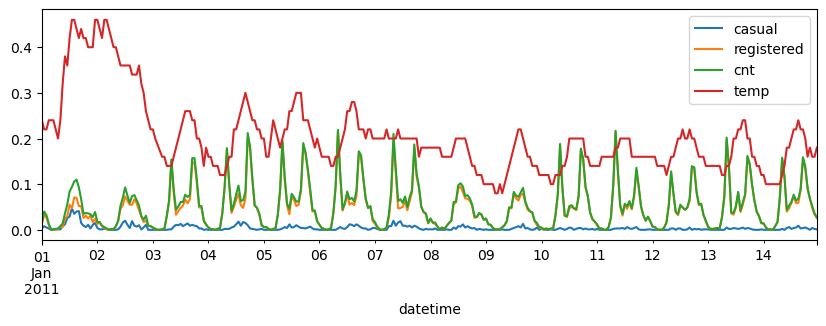

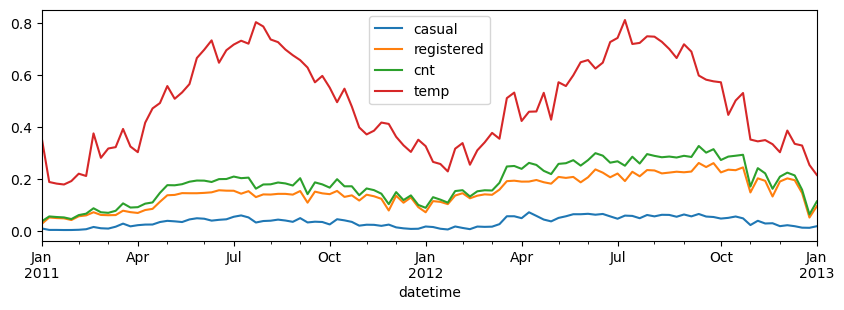

In [89]:
print(df.notna().sum())
print(df[['casual', 'registered', 'cnt', 'weathersit']].describe())

#First graph
df_2weeks = df[:24 * 7 * 2]
df_2weeks[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10, 3))

#Second graph
df_daily = df.resample('W').mean()
df_daily[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10, 3))

## 2.3 Base indicators

In [90]:
mae_daily = df['cnt'].diff(24).abs().mean() * 1e3
mae_weekly = df['cnt'].diff(24 * 7).abs().mean() * 1e3

print(f'MAE daily: {mae_daily} bikes, weekly: {mae_weekly} bikes')

# save to pickle
with open('mae_baseline.pkl', 'wb') as f:
    pickle.dump((mae_daily, mae_weekly), f)

MAE daily: 63.79497716894976 bikes, weekly: 52.42506906077348 bikes


## 2.4 Desnse neural network prediction 

In [91]:
cnt_train = df['cnt']['2011-01-01 00:00':'2012-06-30 23:00']
cnt_valid = df['cnt']['2012-07-01 00:00':]

seq_len = 1 * 24
train_ds = tf.keras.utils.timeseries_dataset_from_array(
cnt_train.to_numpy(),
targets=cnt_train[seq_len:],
sequence_length=seq_len,
batch_size=32,
shuffle=True,
seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
cnt_valid.to_numpy(),
targets=cnt_valid[seq_len:],
sequence_length=seq_len,
batch_size=32
)

number_of_epochs = 20

In [92]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(1, input_shape=[seq_len])
])

# compile with huber loss
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])
model.summary()
model.fit(train_ds, epochs=number_of_epochs, validation_data=valid_ds)

model.save('model_linear.h5')



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-06-22 20:46:22.436277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13104]
	 [[{{node Placeholder/_8}}]]
2023-06-22 20:46:22.436998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [13104]
	 [[{{node Placeholder/_20}}]]


391/410 [===========================>..] - ETA: 0s - loss: 0.0280 - mae: 0.1848

2023-06-22 20:46:23.900505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4392]
	 [[{{node Placeholder/_8}}]]
2023-06-22 20:46:23.900968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


410/410 [==============================] - 2s 4ms/step - loss: 0.0276 - mae: 0.1833 - val_loss: 0.0379 - val_mae: 0.2253
Epoch 2/20
410/410 [==============================] - 2s 4ms/step - loss: 0.0143 - mae: 0.1307 - val_loss: 0.0242 - val_mae: 0.1741
Epoch 3/20
410/410 [==============================] - 2s 4ms/step - loss: 0.0100 - mae: 0.1069 - val_loss: 0.0188 - val_mae: 0.1482
Epoch 4/20
410/410 [==============================] - 1s 3ms/step - loss: 0.0083 - mae: 0.0949 - val_loss: 0.0162 - val_mae: 0.1347
Epoch 5/20
410/410 [==============================] - 1s 3ms/step - loss: 0.0073 - mae: 0.0885 - val_loss: 0.0147 - val_mae: 0.1272
Epoch 6/20
410/410 [==============================] - 1s 3ms/step - loss: 0.0067 - mae: 0.0845 - val_loss: 0.0136 - val_mae: 0.1221
Epoch 7/20
410/410 [==============================] - 1s 3ms/step - loss: 0.0063 - mae: 0.0815 - val_loss: 0.0127 - val_mae: 0.1182
Epoch 8/20
410/410 [==============================] - 1s 3ms/step - loss: 0.0059 - mae:

In [93]:
# evaluate
metrics = model.evaluate(valid_ds)

# scale all metrics back
metrics = (metrics[1] * 1e3,)
print(metrics)

with open('mae_linear.pkl', 'wb') as f:
    pickle.dump(metrics, f)


138/138 [==============================] - 0s 2ms/step - loss: 0.0073 - mae: 0.0908
(90.83844721317291,)


## 2.5 Simple recurrent neural network

In [94]:
model = tf.keras.Sequential([
tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# compile with huber loss
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])
model.summary()
model.fit(train_ds, epochs=number_of_epochs, validation_data=valid_ds)
model.save('model_rnn1.h5')

# evaluate
metrics = model.evaluate(valid_ds)

# scale all metrics back
metrics = (metrics[1] * 1e3,)
print(metrics)
with open('mae_rnn1.pkl', 'wb') as f:
    pickle.dump(metrics, f)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
410/410 [==============================] - 4s 7ms/step - loss: 0.0287 - mae: 0.1813 - val_loss: 0.0618 - val_mae: 0.2641
Epoch 2/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0236 - mae: 0.1655 - val_loss: 0.0507 - val_mae: 0.2389
Epoch 3/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0201 - mae: 0.1526 - val_loss: 0.0437 - val_mae: 0.2204
Epoch 4/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0174 - mae: 0.1415 - val_loss: 0.0376 - val_mae: 0.2036
Epoch 5/20
410/410 [==============================] - 3s 7m

Expand the network (creating a new one with 32 neurons in recurrent layer and 1 neuron in dense layer)

In [95]:
model = tf.keras.Sequential([
tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
tf.keras.layers.Dense(1)
])

# compile with huber loss
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])
model.summary()
model.fit(train_ds, epochs=number_of_epochs, validation_data=valid_ds)
model.save('model_rnn32.h5')

# evaluate
metrics = model.evaluate(valid_ds)

# scale all metrics back
metrics = (metrics[1] * 1e3,)

with open('mae_rnn32.pkl', 'wb') as f:
    pickle.dump(metrics, f)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 32)                1088      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
410/410 [==============================] - 4s 8ms/step - loss: 0.0080 - mae: 0.0910 - val_loss: 0.0102 - val_mae: 0.1020
Epoch 2/20
410/410 [==============================] - 3s 8ms/step - loss: 0.0041 - mae: 0.0630 - val_loss: 0.0077 - val_mae: 0.0881
Epoch 3/20
410/410 [==============================] - 3s 8ms/step - loss: 0.0034 - mae: 0.0574 - val_loss: 0.0066 - val_mae: 0.0828
Epoch 4/20
410/410 [==============================]

## 2.6 Deep RNN

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

# compile with huber loss
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])
model.summary()
model.fit(train_ds, epochs=number_of_epochs, validation_data=valid_ds)
model.save('model_rnn_deep.h5')

# evaluate
metrics = model.evaluate(valid_ds)

# scale all metrics back
metrics = (metrics[1] * 1e3,)
with open('mae_rnn_deep.pkl', 'wb') as f:
    pickle.dump(metrics, f)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, None, 32)          1088      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
410/410 [==============================] - 9s 18ms/step - loss: 0.0104 - mae: 0.0948 - val_loss: 0.0093 - val_mae: 0.1027
Epoch 2/20
410/410 [==============================

## 2.7 Multilayer model

In [97]:

features = df[['cnt', 'weathersit', 'atemp', 'workingday']]
train_mv = features['2011-01-01 00:00':'2012-06-30 23:00']
valid_mv = features['2012-07-01 00:00':]

seq_len = 24
train_ds_mv = tf.keras.utils.timeseries_dataset_from_array(
    train_mv.to_numpy(),
    targets=train_mv['cnt'][seq_len:],
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds_mv = tf.keras.utils.timeseries_dataset_from_array(
    valid_mv.to_numpy(),
    targets=valid_mv['cnt'][seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

model_rnn_mv = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)
])

model_rnn_mv.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

history = model_rnn_mv.fit(train_ds_mv, validation_data=valid_ds_mv, epochs=20)

model_rnn_mv.save('model_rnn_mv.h5')

preds_mv = model_rnn_mv.predict(valid_ds_mv)
true_values_mv = np.concatenate([y.numpy() for x, y in valid_ds_mv])
mae_rnn_mv = mean_absolute_error(true_values_mv, preds_mv)

with open('mae_rnn_mv.pkl', 'wb') as f:
    pickle.dump((mae_rnn_mv,), f)

Epoch 1/20


2023-06-22 20:51:12.522184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13128,4]
	 [[{{node Placeholder/_0}}]]
2023-06-22 20:51:12.522698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [13104]
	 [[{{node Placeholder/_20}}]]


408/410 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0871

2023-06-22 20:51:16.245398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [4392]
	 [[{{node Placeholder/_20}}]]
2023-06-22 20:51:16.246961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4392]
	 [[{{node Placeholder/_8}}]]


410/410 [==============================] - 4s 8ms/step - loss: 0.0078 - mae: 0.0870 - val_loss: 0.0074 - val_mae: 0.0843
Epoch 2/20
410/410 [==============================] - 3s 8ms/step - loss: 0.0034 - mae: 0.0580 - val_loss: 0.0064 - val_mae: 0.0753
Epoch 3/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0029 - mae: 0.0529 - val_loss: 0.0068 - val_mae: 0.0788
Epoch 4/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0027 - mae: 0.0506 - val_loss: 0.0056 - val_mae: 0.0708
Epoch 5/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0026 - mae: 0.0498 - val_loss: 0.0052 - val_mae: 0.0688
Epoch 6/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0025 - mae: 0.0487 - val_loss: 0.0047 - val_mae: 0.0662
Epoch 7/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0024 - mae: 0.0480 - val_loss: 0.0049 - val_mae: 0.0679
Epoch 8/20
410/410 [==============================] - 3s 7ms/step - loss: 0.0023 - mae: